In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
data_path = '../data/cleandata/train_Zip_onehot.csv'
df = pd.read_csv(data_path)
df['Zip_cluster_0'] = df['Zip_cluster_0'].apply(lambda x: 1 if x else 0)
df['Zip_cluster_1'] = df['Zip_cluster_1'].apply(lambda x: 1 if x else 0)
df.head(5)


,ID,YearBuilt,SqFt,Story,Acres,Baths,Fireplaces,Value,Zip_cluster_0,Zip_cluster_1
0,1,1990,2102,1.0,0.77,2.0,1,203200,0,0
1,2,1986,1740,1.5,0.06,3.0,1,119096,0,0
2,3,1955,795,1.0,0.30,1.0,0,71666,0,0
3,4,1983,1152,1.0,0.68,2.0,0,131103,0,0
4,6,1924,1829,1.5,0.25,3.0,1,496425,1,0


### 1. Examine the VIF of the features
All features have a VIF of less than 5, no multicollinearity is present.

In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    # 为了计算 VIF，X 必须包含常数项
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.drop(0)  # 去掉常数项的 VIF

X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip_cluster_0', 'Zip_cluster_1']]
calculate_vif(X)


,feature,VIF
1,YearBuilt,1.340332
2,SqFt,2.805735
3,Story,1.717654
4,Acres,1.215395
5,Baths,2.078907
6,Fireplaces,1.547377
7,Zip_cluster_0,1.642051
8,Zip_cluster_1,1.736994


In [13]:
# Fit the linear regression model without 'ID'
model = smf.ols('Value ~ YearBuilt + SqFt + Story + Acres + Baths + Fireplaces + Zip_cluster_0 + Zip_cluster_1', data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.776
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     34.26
Date:                Thu, 14 Nov 2024   Prob (F-statistic):           1.18e-22
Time:                        13:04:37   Log-Likelihood:                -1084.2
No. Observations:                  88   AIC:                             2186.
Df Residuals:                      79   BIC:                             2209.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.635e+06    8.3e+05      4.379      0.000    1.98e+06    5.29e+06
YearBuilt     -1865.9294    427.342     -4.366      0.000   -2716.532   -1015.326
SqFt             87.5802     15.333      5.712      0.000      57.061     118.099
Story          1.743e+04   1.79e+04      0.972      0.334   -1.83e+04    5.32e+04
Acres          3.584e+04   2.06e+04      1.738      0.086   -5203.157    7.69e+04
Baths         -1053.2612   1.52e+04     -0.069      0.945   -3.13e+04    2.92e+04
Fireplaces     3.821e+04   1.63e+04      2.338      0.022    5676.501    7.07e+04
Zip_cluster_0  6.264e+04   1.57e+04      4.000      0.000    3.15e+04    9.38e+04
Zip_cluster_1  1.602e+05   3.48e+04      4.609      0.000     9.1e+04    2.29e+05
==============================================================================
Omnibus:                        6.252   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                6.280
Skew:                           0.427   Prob(JB):                       0.0433
Kurtosis:                       3.992   Cond. No.                     3.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
## Calculate LOOCV
# Get the number of observations
n = df.shape[0]
# Get the predicted values
pred = model.predict()
# Calculate the hat matrix
X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip_cluster_0', 'Zip_cluster_1']]
X = sm.add_constant(X)
hat = model.get_influence().hat_matrix_diag
# Calculate the residuals
resid = model.resid
LOOCV = np.sum((resid / (1 - hat))**2) / n
print('LOOCV:', LOOCV)
print('RMSE:', np.sqrt(LOOCV))

LOOCV: 4141912303.7141833
RMSE: 64357.69032302343


Text(0, 0.5, 'Residual')

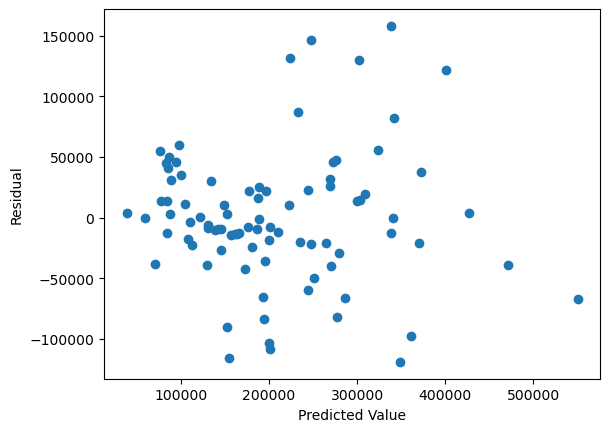

In [15]:
# residual plot
plt.scatter(pred, resid)
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

### Best subset selection

In [16]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm

def best_subset_regression(X, y):
    """
    Perform best subset regression to find the best model with any number of predictors.
    
    Parameters:
        X (DataFrame): DataFrame containing predictor variables.
        y (Series): Series containing the response variable.
        
    Returns:
        results (DataFrame): DataFrame with details of each subset and their R² and AIC values.
        best_model (dict): Dictionary with details of the best subset model.
    """
    # Create lists to store results
    models = []
    
    # Iterate over all possible subset sizes
    for k in range(1, len(X.columns) + 1):
        # Iterate over all combinations of features of size k
        for combo in itertools.combinations(X.columns, k):
            # Fit the model with the selected subset of features
            X_subset = X[list(combo)]
            X_subset = sm.add_constant(X_subset)  # Add a constant term to the model
            model = sm.OLS(y, X_subset).fit()
            
            # Store the model performance metrics
            models.append({
                "num_features": k,
                "features": combo,
                "R_squared": model.rsquared,
                "Adj_R_squared": model.rsquared_adj,
                "AIC": model.aic
            })
    
    # Convert results to DataFrame for easier viewing and sorting
    results = pd.DataFrame(models)
    
    # Find the model with the highest R² or lowest AIC
    best_model_adj_r2 = results.loc[results["Adj_R_squared"].idxmax()]
    best_model_aic = results.loc[results["AIC"].idxmin()]
    
    # Return all results and the best model by R² and AIC
    return results, {"best_by_Adj_R2": best_model_adj_r2, "best_by_AIC": best_model_aic}

# 示例使用
# results, best_model = best_subset_regression(X, y)
# print("All model results:\n", results)
# print("Best model by R²:\n", best_model["best_by_R2"])
# print("Best model by AIC:\n", best_model["best_by_AIC"])

In [26]:
# Fit the best subset regression model
# X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip']]
X = df[['YearBuilt', 'SqFt', 'Story', 'Acres', 'Baths', 'Fireplaces', 'Zip_cluster_0', 'Zip_cluster_1']]
y = df['Value']
results, best_model = best_subset_regression(X, y)
print("Best model by R²:\n", best_model["best_by_Adj_R2"])
print("Best model by AIC:\n", best_model["best_by_AIC"])
best_features = best_model["best_by_Adj_R2"]["features"]

Best model by R²:
 num_features                                                     6
features         (YearBuilt, SqFt, Acres, Fireplaces, Zip_clust...
R_squared                                                 0.773557
Adj_R_squared                                             0.756784
AIC                                                    2183.436287
Name: 231, dtype: object
Best model by AIC:
 num_features                                                     6
features         (YearBuilt, SqFt, Acres, Fireplaces, Zip_clust...
R_squared                                                 0.773557
Adj_R_squared                                             0.756784
AIC                                                    2183.436287
Name: 231, dtype: object


# Prediction on the test set

In [23]:
test = pd.read_csv('../data/cleandata/test_Zip_onehot.csv')
test['Zip_cluster_0'] = test['Zip_cluster_0'].apply(lambda x: 1 if x else 0)
test['Zip_cluster_1'] = test['Zip_cluster_1'].apply(lambda x: 1 if x else 0)

In [29]:
best_features = list(best_features)

In [32]:
X_train = df[best_features]
X_train = sm.add_constant(X_train)
X_test = test[best_features]
X_test = sm.add_constant(X_test)
## make prediction
model_final = sm.OLS(y, X_train).fit()
pred = model_final.predict(X_test)
pred

0    185941.216651
1    298201.507165
2     41039.674658
3    256597.620103
4     82778.328855
5    172124.494340
6    219847.716219
7     50692.148989
8    194373.643517
9    154073.193520
dtype: float64

In [35]:
prediction = pd.DataFrame({'ID': test['ID'], 'Outcome': pred})
prediction

,ID,Outcome
0,1,185941.216651
1,2,298201.507165
2,3,41039.674658
3,4,256597.620103
4,5,82778.328855
5,6,172124.494340
6,7,219847.716219
7,8,50692.148989
8,9,194373.643517
9,10,154073.193520


In [36]:
## Save the prediction to a CSV file
import os
if not os.path.exists('../data/predictions'):
    os.makedirs('../data/predictions')
prediction.to_csv('../data/predictions/prediction_best_subset_onehot.csv', index=False)